In [328]:
import os
import shutil
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

Data extraction
--

In [526]:
shutil.unpack_archive("xp.tar.gz")

In [655]:
directory = "output"
df_run = pd.concat([
    pd.read_csv(f"{directory}/watdiv/run.csv"),
    pd.read_csv(f"{directory}/wikidata/run.csv")
])
df_check = pd.read_csv(f"{directory}/watdiv/check.csv")

In [529]:
df_check.head()

,correct,query,limit,approach,workload,xp
0,True,L4,10,sage,watdiv,stateless
1,True,L4,10,sage,watdiv,stateless
2,True,L4,10,sage,watdiv,stateless
3,True,L4,10,sage,watdiv,stateless
4,True,L4,100,sage,watdiv,stateless


In [530]:
df_run.head()

,execution_time,data_transfer,http_calls,solutions,resuming_time,saving_time,query,run,limit,quota,approach,workload,xp
0,257.355928,4725483.0,2,10,3.509283,0.117064,L4,1,10,100,sage,watdiv,stateless
1,265.358210,4725483.0,2,10,4.445553,0.177145,L4,2,10,100,sage,watdiv,stateless
2,259.510517,4725482.0,2,10,3.780127,0.190735,L4,3,10,100,sage,watdiv,stateless
3,278.250217,4725482.0,2,10,4.383087,0.120401,L4,1,10,500,sage,watdiv,stateless
4,275.343418,4725482.0,2,10,4.130602,0.169992,L4,2,10,500,sage,watdiv,stateless


Validation Step - Results have been compared with Virtuoso
--

In [531]:
total = df_check.shape[0]
nb_correct = df_check[df_check["correct"] == True].shape[0]

print(f"{nb_correct}/{total} correct solutions")

3840/3840 correct solutions


Data Exploration
--

In [612]:
quota = 100
limit = 100
approaches = ["sage", "sage-topk", "sage-partial-topk"]
workloads = ["watdiv", "watdiv-desc"]

df = pd.concat([
    df_run[(df_run["xp"] == "stateless")
        & (df_run["workload"].isin(workloads))
        & (df_run["quota"] == quota)
        & (df_run["limit"] == limit)
        & (df_run["approach"].isin(approaches))].copy(deep=True),
    df_run[(df_run["xp"] == "statefull")
        & (df_run["workload"].isin(workloads))
        & (df_run["quota"] == quota)
        & (df_run["limit"] == limit)
        & (df_run["approach"] == "sage-topk")].copy(deep=True)
])

df.loc[df["xp"] == "statefull", "approach"] = df["approach"] + "-statefull"
df["limit"] = "LIMIT " + df["limit"].astype(str)
df["quota"] = df["quota"].astype(str)
df["execution_time"] /= 1000
df["saving_time"] /= 1000
df["resuming_time"] /= 1000
df["data_transfer"] /= 1024**2

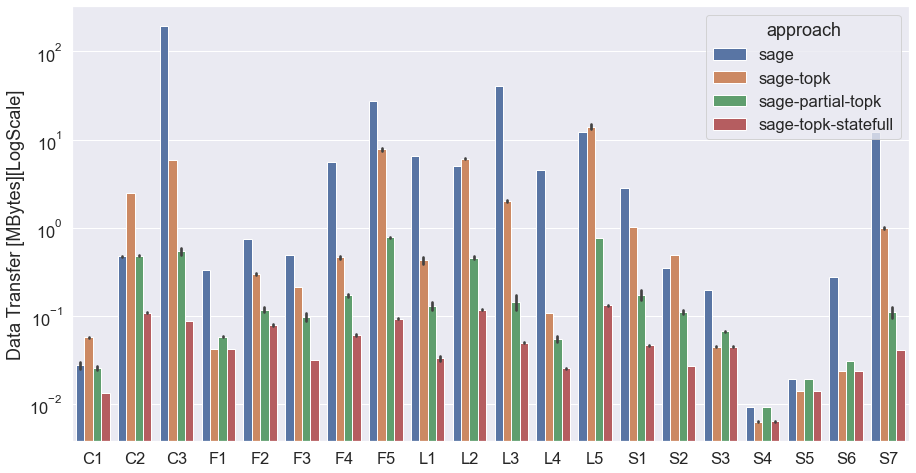

In [552]:
chart = sns.barplot(data=df, x="query", y="data_transfer", hue="approach", order=plot_order)
chart.set_yscale("log")
chart.set_ylabel("Data Transfer [MBytes][LogScale]")
chart.set_xlabel("")

plt.show(chart)

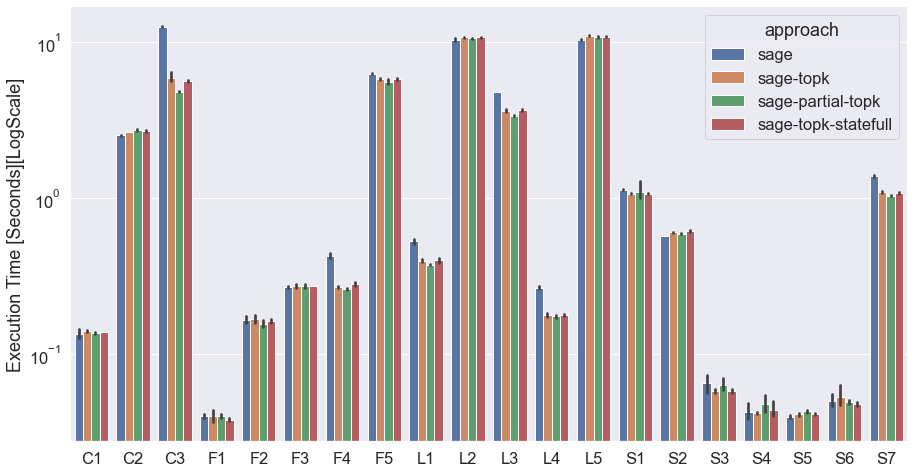

In [553]:
chart = sns.barplot(data=df, x="query", y="execution_time", hue="approach", order=plot_order)
chart.set_yscale("log")
chart.set_ylabel("Execution Time [Seconds][LogScale]")
chart.set_xlabel("")

plt.show(chart)

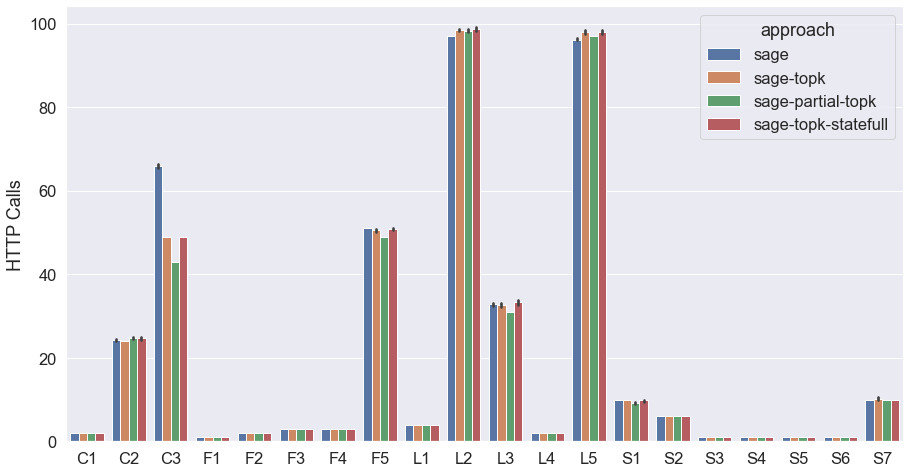

In [554]:
chart = sns.barplot(data=df, x="query", y="http_calls", hue="approach", order=plot_order)
chart.set_ylabel("HTTP Calls")
chart.set_xlabel("")

plt.show(chart)

What is the impact of quotas and k on both the execution time, the data transfer and the number of HTTP calls?
--

In [638]:
approaches = ["sage", "sage-topk", "sage-partial-topk"]
workloads = ["watdiv", "watdiv-desc"]

df = pd.concat([
    df_run[(df_run["xp"] == "stateless")
        & (df_run["workload"].isin(workloads))
        & (df_run["approach"].isin(approaches))].copy(deep=True),
    df_run[(df_run["xp"] == "statefull")
        & (df_run["workload"].isin(workloads))
        & (df_run["approach"] == "sage-topk")].copy(deep=True)
])
df.loc[df["xp"] == "statefull", "approach"] = df["approach"] + "-statefull"
df["limit"] = "LIMIT " + df["limit"].astype(str)
df["quota"] = df["quota"].astype(str)
df["execution_time"] /= 1000
df["saving_time"] /= 1000
df["resuming_time"] /= 1000
df["data_transfer"] /= 1024**2

df = df.groupby(by=["approach", "quota", "limit", "run"]).sum().reset_index()
df = df.groupby(by=["approach", "quota", "limit"]).mean().reset_index()

## Impact on Data Transfer

In [639]:
base = alt.Chart(df).properties(height=225, width=300)

base.mark_line().encode(
    x=alt.X(
        "quota:N",
        title="Quota [ms]",
        sort=["10000", "1000", "500", "100"],
        axis=alt.Axis(labelAngle=0)
    ),
    y=alt.Y(
        "data_transfer:Q",
        title="Data Transfer [MB][LogScale]",
        scale=alt.Scale(zero=False, type="log")
    ),
    color=alt.Color(
        "approach:N",
        legend=alt.Legend(
            title="Approaches",
            labelFontSize=20,
            titleFontSize=18,
            orient="bottom",
            labelLimit=300,
            symbolStrokeWidth=10
        )
    ),
    facet=alt.Facet(
        "limit:N",
        columns=2,
        header=alt.Header(
            title=None,
            labelFontSize=18
        )
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
).resolve_scale(
    y="independent"
)

alt.Chart(...)

## Impact on Execution Time

In [634]:
base = alt.Chart(df).properties(height=120, width=300)

base.mark_line().encode(
    x=alt.X(
        "quota:N",
        title="Quota [ms]",
        sort=["10000", "1000", "500", "100"],
        axis=alt.Axis(labelAngle=0)
    ),
    y=alt.Y(
        "execution_time:Q",
        title="Execution Time",
        scale=alt.Scale(zero=False)
    ),
    color=alt.Color(
        "approach:N",
        legend=None
    ),
    facet=alt.Facet(
        "limit:N",
        columns=1,
        header=alt.Header(
            title=None,
            labelFontSize=16
        )
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
).resolve_scale(
    y="independent"
)

alt.Chart(...)

## Impact on number of HTTP Calls

In [637]:
base = alt.Chart(df).properties(height=120, width=300)

base.mark_line().encode(
    x=alt.X(
        "quota:N",
        title="Quota [ms]",
        sort=["10000", "1000", "500", "100"],
        axis=alt.Axis(labelAngle=0)
    ),
    y=alt.Y(
        "http_calls:Q",
        title="HTTP Calls",
        scale=alt.Scale(zero=False)
    ),
    color=alt.Color(
        "approach:N",
        legend=alt.Legend(
            title="Approaches",
            labelFontSize=20,
            titleFontSize=18,
            labelLimit=300,
            symbolStrokeWidth=10
        )
    ),
    facet=alt.Facet(
        "limit:N",
        columns=1,
        header=alt.Header(
            title=None,
            labelFontSize=16
        )
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=19
).resolve_scale(
    y="independent"
)

alt.Chart(...)

Why Data Transfer increases so much when using the top-k iterator?
--

In [653]:
approach = "sage-partial-topk"
workloads = ["watdiv", "watdiv-desc"]

df = df_run[(df_run["xp"] == "stateless")
    & (df_run["approach"] == approach)
    & (df_run["workload"].isin(workloads))].copy(deep=True)

df["limit"] = "LIMIT " + df["limit"].astype(str)
df["quota"] = df["quota"].astype(str)
df["execution_time"] /= 1000
df["saving_time"] /= 1000
df["resuming_time"] /= 1000
df["data_transfer"] /= 1024**2
df["execution_time"] -= (df["resuming_time"] + df["saving_time"])

df = df.groupby(by=["approach", "quota", "limit", "run"]).sum().reset_index()
df = df.groupby(by=["approach", "quota", "limit"]).mean().reset_index()

In [654]:
alt.Chart(df).transform_fold(
    ["resuming_time", "saving_time", "execution_time"],
    as_=["steps", "time"]
).mark_bar().encode(
    x=alt.X("limit:N", title="", axis=alt.Axis(labelAngle=-45)),
    y=alt.Y("time:Q", title="Execution Time [Seconds]"),
    column=alt.Column(
        "quota:N",
        title="Quota [ms]",
        sort=["10000", "1000", "500", "100"],
        header=alt.Header(labelFontSize=18, titleFontSize=18)
    ),
    color=alt.Color(
        "steps:N",
        legend=alt.Legend(
            title="",
            labelFontSize=18,
            titleFontSize=18,
            orient="bottom",
            symbolStrokeWidth=10
        )
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=20
)

alt.Chart(...)

What is the impact of early pruning on both the execution time, the data transfer and the number of HTTP calls?
--

In [621]:
approaches = ["sage-topk", "sage-partial-topk"]
workloads = ["watdiv", "watdiv-desc"]

df = df_run[(df_run["xp"].isin(["stateless", "earlypruning"]))
    & (df_run["approach"].isin(approaches))
    & (df_run["workload"].isin(workloads))].copy(deep=True)

df.loc[df["xp"] == "earlypruning", "approach"] = df["approach"] + "-earlypruning"
df["limit"] = "LIMIT " + df["limit"].astype(str)
df["quota"] = df["quota"].astype(str)
df["execution_time"] /= 1000
df["saving_time"] /= 1000
df["resuming_time"] /= 1000
df["data_transfer"] /= 1024**2
df["execution_time"] -= (df["resuming_time"] + df["saving_time"])

df = df.groupby(by=["xp", "approach", "quota", "limit", "run"]).sum().reset_index()
df = df.groupby(by=["xp", "approach", "quota", "limit"]).mean().reset_index()

In [622]:
base = alt.Chart(df).properties(height=200, width=300)

base.mark_line().encode(
    x=alt.X(
        "quota:N",
        title="Quota [ms]",
        sort=["10000", "1000", "500", "100"],
        axis=alt.Axis(labelAngle=0)
    ),
    y=alt.Y(
        "execution_time:Q",
        title="Execution Time [Seconds]",
        scale=alt.Scale(zero=False)
    ),
    color=alt.Color(
        "approach:N",
        legend=alt.Legend(
            title="Approaches",
            labelFontSize=18,
            titleFontSize=18,
            orient="bottom",
            labelLimit=300,
            symbolStrokeWidth=10
        )
    ),
    facet=alt.Facet(
        "limit:N",
        columns=2,
        header=alt.Header(title=None, labelFontSize=16)
    )
).configure_axis(
    labelFontSize=15,
    titleFontSize=18
).resolve_scale(
    y="independent"
)

alt.Chart(...)

In [563]:
for quota in df["quota"].unique():
    print(f"quota: {quota}ms")
    for limit in df["limit"].unique():
        print(f"-- limit: {limit}")
        for approach in ["sage-topk", "sage-partial-topk"]:
            exec_without = float(df[(df["approach"] == approach)
                & (df["quota"] == quota)
                & (df["limit"] == limit)]["execution_time"])
            exec_with = float(df[(df["approach"] == f"{approach}-earlypruning")
                & (df["quota"] == quota)
                & (df["limit"] == limit)]["execution_time"])
            print(f"---- {approach}: ({exec_without} - {exec_with}) - {round(1 - (exec_with/exec_without), 2)*100}%")

quota: 100ms
-- limit: LIMIT 10
---- sage-topk: (80.18798915545146 - 27.96812693277995) - 65.0%
---- sage-partial-topk: (78.43114868799846 - 28.152416467666626) - 64.0%
-- limit: LIMIT 100
---- sage-topk: (81.81756440798442 - 30.097726106643677) - 63.0%
---- sage-partial-topk: (79.47324744860332 - 30.279370943705242) - 62.0%
-- limit: LIMIT 1000
---- sage-topk: (92.38546172777812 - 41.81902321179708) - 55.00000000000001%
---- sage-partial-topk: (81.08100565274556 - 39.7494281133016) - 51.0%
-- limit: LIMIT 10000
---- sage-topk: (174.51855341593424 - 133.37239853541055) - 24.0%
---- sage-partial-topk: (93.64797878265381 - 77.82113202412923) - 17.0%
quota: 1000ms
-- limit: LIMIT 10
---- sage-topk: (76.81157819430034 - 26.23802924156189) - 66.0%
---- sage-partial-topk: (75.63980722427368 - 26.24926233291626) - 65.0%
-- limit: LIMIT 100
---- sage-topk: (77.06726678212483 - 28.043599605560303) - 64.0%
---- sage-partial-topk: (76.13542135556538 - 28.01944637298584) - 63.0%
-- limit: LIMIT 10

What is the result on real data?
--

In [656]:
approaches = ["sage", "sage-topk", "sage-partial-topk"]
workloads = ["wikidata"]

df = df_run[(df_run["xp"].isin(["stateless", "earlypruning"]))
    & (df_run["approach"].isin(approaches))
    & (df_run["workload"].isin(workloads))].copy(deep=True)

df.loc[df["xp"] == "earlypruning", "approach"] = df["approach"] + "-earlypruning"
df["limit"] = "LIMIT " + df["limit"].astype(str)
df["quota"] = df["quota"].astype(str)
df["execution_time"] /= 1000
df["saving_time"] /= 1000
df["resuming_time"] /= 1000
df["data_transfer"] /= 1024**2

df = df.groupby(by=["xp", "approach", "quota", "limit", "run"]).sum().reset_index()
df = df.groupby(by=["xp", "approach", "quota", "limit"]).mean().reset_index()

In [664]:
base = alt.Chart(df).properties(height=250, width=300)

base.mark_line().encode(
    x=alt.X(
        "quota:N",
        title="Quota [ms]",
        sort=["10000", "1000", "500", "100"],
        axis=alt.Axis(labelAngle=0)
    ),
    y=alt.Y(
        "execution_time:Q",
        title="Execution Time [Seconds]",
        scale=alt.Scale(zero=False)
    ),
    color=alt.Color(
        "approach:N",
        legend=alt.Legend(
            title="Approaches",
            labelFontSize=18,
            titleFontSize=18,
            labelLimit=300,
            symbolStrokeWidth=10
        )
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=19
)

alt.Chart(...)

In [665]:
base = alt.Chart(df).properties(height=250, width=300)

base.mark_line().encode(
    x=alt.X(
        "quota:N",
        title="Quota [ms]",
        sort=["10000", "1000", "500", "100"],
        axis=alt.Axis(labelAngle=0)
    ),
    y=alt.Y(
        "data_transfer:Q",
        title="Data Transfer [MB]",
        scale=alt.Scale(zero=False)
    ),
    color=alt.Color(
        "approach:N",
        legend=None
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=19
)

alt.Chart(...)

In [666]:
base = alt.Chart(df).properties(height=250, width=300)

base.mark_line().encode(
    x=alt.X(
        "quota:N",
        title="Quota [ms]",
        sort=["10000", "1000", "500", "100"],
        axis=alt.Axis(labelAngle=0)
    ),
    y=alt.Y(
        "http_calls:Q",
        title="HTTP Calls",
        scale=alt.Scale(zero=False)
    ),
    color=alt.Color(
        "approach:N",
        legend=None
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=19
)

alt.Chart(...)